In [1]:
import time
import cv2
from matplotlib import pyplot as plt
import numpy as np
import random
from math import sqrt, ceil, log10
from pandas import DataFrame, concat

import os
import pandas as pd

Import functions

In [2]:
from util_geometric_transf import make_radPattern_im
from util_statistic import monteCarlo_reg
from util_bootstrap import Kybic_bs
from util_registration import transf_2stage_estim
from util_crlb import crlb__by_RI_interp
from util_features import max_diff
from util_registration import similarity_transform
from util_features import spectral_width

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Parameters

In [3]:
'''
Comments:
    XXX - The choise of detector (and descriptor) in monteCarlo_reg 
          (ri keypoints preparatory evaluation to speed-up) should be match with 
          corresponding item in function keypoint_estim. By default the 'sift'
          keypoints are used.
'''
#%%
# XXX - Attension
random.seed() 
np.random.seed()

# --- DEBUG ---
# random.seed(13) 
# np.random.seed(13)

# random.seed(13) 
# np.random.seed(5323)
# ---------------------

In [4]:
mode = 'test'      # 'train', 'test'                                                     # Attension.
used_map = 'AVIRIS_d'      # 'AVIRIS_a',  'AVIRIS_d', 'Dnipro', 'Gavana'                  # Attension. 

nPoints = 2_000       # for train                                                        # Attension.
# nPoints = 880       # for test                                                       
# nPoints = 100     # Number of created image pairs


nTest = 200     # Number of Monte-Carlo experiments to evaluate ground truth RMSE
# Number of bootstrap samples.
nB = 100

# --- DEBUG ---
# nTest = 100
# nB = 50
# -------------------

In [5]:
#%%
t = time.time()
# RI - reference image
# CI - current image

# Magnitude snr (not dB), real.
snr_min = 3
snr_max = 40               

# CI min-max sizes.
ci_s_min = 40
ci_s_max = 60

# RI averaging zone radius min-max.
# Averaging zone used for image formation based on initial high-resolution image (large map).
rz_ri_min = 3
rz_ri_max = 5

# Load images

In [6]:
#%%
# Path with only ASCII letters.
if used_map == 'AVIRIS_a':
    path = '/kaggle/input/maps-aviris-dnipro/Ga.tif'
elif used_map == 'AVIRIS_d':
    path = '/kaggle/input/maps-aviris-dnipro/Gd.tif'                                 
elif used_map == 'Dnipro':
    path = '/kaggle/input/maps-aviris-dnipro/PAN_020828_cut_geo.tif'
# elif used_map == 'Gavana':
#     path = r'G:\Learn\scientific work\images\gavana_gray.tif'      # missing
else:
    raise ValueError('Wrong used_map')
    
# print(path)

In [7]:
source_map = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
source_map = np.float32(source_map)
N = np.size(source_map,0)
M = np.size(source_map,1)


# If mode == train  we will use the left half of large map,
# If mode == test  we will use the right half.
iBorder = int(M/2)
if mode == 'train':
    source_map = source_map[:,:iBorder]
    M = iBorder
elif mode == 'test':
    source_map = source_map[:,iBorder:]
    M = M-iBorder
    
print('N,M = ', N, M)

N,M =  614 1293


# Create data

In [8]:
from multiprocessing import Pool

df = DataFrame()

# Array for store images and errors.
# sim_storage = []

ci_ri_list = []

def process_point(ind):
    #%% Geometric transformation (GT).
    shift_x = random.uniform(-0.5,0.5)     # Shifts in RI grid.
    shift_y = random.uniform(-0.5,0.5)
    scale = random.uniform(0.5,1.5)
    rot = random.uniform(-180,180)
    # As estimated GT parameters will be (center_x, center_y, scale, rot)
    #      [center_x, center_y - coordinates of CI center relative to RI grid],
    # [center_x, center_y may be considered as shifts in transformation model,
    #  if we assume that origin of the CI reference system lies in the center of CI;
    #  see the (1) model with explanation im MRRS-2020 paper for details].

    # Model SNR from 3 to 40 (as SD ratio, not dB).
    snr = 10**( random.uniform(0,1) *log10( snr_max-snr_min+1 ) )
    snr = snr + snr_min-1
    
    # Consider the current image be squared.
    ci_s = random.randint(ci_s_min,ci_s_max)                                
    
    # Averaging radius for RI.
    Rz_ri = random.uniform(rz_ri_min, rz_ri_max)                               
    step = Rz_ri
    
    # Search field size (how much RI is greater on each side than CI).
    search_s = 3
    
    #%%
    # Reference image size (we form in such a way that the CI is always inside it).
    # Consider the RI be squared.
    ri_s = scale*sqrt(ci_s**2 + ci_s**2) +2*search_s
    ri_s = ceil(ri_s)+1
    
    # Size of high resolution (HR) fragment for RI creation.
    ri_s_HR = ceil( (ri_s-1)*step + 2*Rz_ri) +1

    # Reserve for RI initial random shift (within HR pixel).
    #    This is don't subpixel shift between RI and CI. It is added to 
    #    diversify the position of RI grid relative to the high-resolution grid.
    ri_s_HR = ri_s_HR + 2
    # Reserve for CI shift (within new pixel).
    ri_s_HR = ri_s_HR + 2*ceil(step/2)
    
    if (ri_s_HR <= N) and (ri_s_HR <= M):     # If the condition is not met - empty iteration.
        i = random.randint(0, N-ri_s_HR)
        j = random.randint(0, M-ri_s_HR)
        ri_HR = source_map[i:i+ri_s_HR, j:j+ri_s_HR]
        
        #%% --- DEBUG ---
        #plt.figure()
        #plt.imshow(ri_HR)
        #plt.gray()
        #plt.show()
        
        (ri,ci_clean,
         center_x,center_y) = make_radPattern_im(ri_HR,ri_s,ci_s,
                                                 Rz_ri,
                                                 shift_x,shift_y,
                                                 scale,rot)
                                                 
        # --- DEBUG ---                                             
    # =============================================================================
    #     plt.figure()
    #     plt.subplot(121)
    #     low_i = np.amin(ri)
    #     high_i = np.amax(ri)
    #     
    #     print()
    #     print('low_i = ',low_i)
    #     print('high_i = ',high_i)
    #     print()
    #     
    #     plt.imshow(ri, vmin=low_i ,vmax=high_i)
    #     plt.gray()
    #     plt.subplot(122)
    #     plt.imshow(ci_clean, vmin=low_i ,vmax=high_i)
    #     plt.gray()
    #     plt.show()
    # =============================================================================
        
        
        #%%
        df_row = DataFrame(index = [ind])  
            # During formation, some indices may be skipped (for idle iterations)
        
        # Ground truth transformation parameters: center_x, center_y, scale, rotation
        gt_true = (center_x,center_y,scale,rot)
           
        df_row['ci_s'] = [ci_s]
        df_row['ri_s'] = [ri_s]
        
        # Ideal (not known after real registration) - for DEBUG.
        df_row['snr'] = [snr]
        df_row['Rz_ri'] = [Rz_ri]
        df_row['shift_x_ideal'] = [shift_x]
        df_row['shift_y_ideal'] = [shift_y]
        df_row['scale_ideal'] = [scale]
        df_row['rot_ideal'] = [rot]
        
        # Ground truth RMSE and P evaluation.
        (Stat_, err_kp, err_ncc) = monteCarlo_reg(ri,ci_clean,
                                                  gt_true,
                                                  snr,nTest)
            
        df_row = concat( [df_row, DataFrame(Stat_,index=[ind])], 
                          axis=1)

        
        #%% 
        # Modeling real registration.
        ci_E = np.std(ci_clean)
        noise_SD = ci_E/snr
        ci = ci_clean + np.random.normal(0,noise_SD, (ci_s,ci_s) )
        
        # XXX - possible slight improvement: to use kp for RI, evaluated in monteCarlo_reg.
        (_, gt_ncc) = transf_2stage_estim(ri,ci)
        
        
        #%% Features.
        
        # Features based on estimated GT parameters.
        center_estim_x = gt_ncc[0]
        center_estim_y = gt_ncc[1]
        
        # Probably such "subpixel" parameters don't make much sense. # XXX
        df_row['subpix_x'] = [ center_estim_x - int(center_estim_x) ]
        df_row['subpix_y'] = [ center_estim_y - int(center_estim_y) ]
        
        df_row['scale'] = [ gt_ncc[2] ]
        df_row['rot'] = [ gt_ncc[3] ]
        
        
        # By interpolation, we calculate the RI fragment corresponding to the CI.
        from scipy.interpolate import RectBivariateSpline as rbs
        (n,m) = ri.shape      
        if n != m:          # The program is designed only for square RI.
            raise ValueError('ri must be squared')
        F = rbs(np.arange(n), np.arange(m), ri)
        ri_fragm, _, _ = similarity_transform(gt_ncc,ci_s,F)    # Return flattened 1D array.
        ri_fragm = ri_fragm.reshape( (ci_s,ci_s), order='F')
        
        mdx,mdy = max_diff(ri_fragm)
        df_row['mdx'] = [ mdx ]
        df_row['mdy'] = [ mdy ]           
                
        widx,widy = spectral_width(ri_fragm)                                         
        df_row['widx'] = [ widx ]
        df_row['widy'] = [ widy ]                                          
                                                 
                                                 
        #%% Yetik and Ko (features continued).
        
# =============================================================================
#         # Variant 1 - Directly implements the formulas in article.
#         from functions.CRLB.add_functions.crlb__by_RI_fragm import crlb__by_RI_fragm
#         crlb, cov_feature = crlb__by_RI_fragm(ri,gt_ncc,
#                                               ci_s,noise_SD)
# =============================================================================

        # Variant 2 - My implementation (almost the same result).                          # Attention - don't used in last version
        crlb, cov_feature = crlb__by_RI_interp(ri,gt_ncc,
                                               ci_s,noise_SD)     

        df_row['CRLB_x'] = crlb[0]
        df_row['CRLB_y'] = crlb[1]
        df_row['CRLB_sc'] = crlb[2]
        df_row['CRLB_rot'] = crlb[3]
        
        # Add CRLB-based features.
        unknown_sigm = 1     
        quasi_crlb = np.sqrt( np.diag(cov_feature) ) * unknown_sigm
        df_row['quasi_CRLB_x'] = quasi_crlb[0]
        df_row['quasi_CRLB_y'] = quasi_crlb[1]
        df_row['quasi_CRLB_sc'] = quasi_crlb[2]
        df_row['quasi_CRLB_rot'] = quasi_crlb[3]
        
    
        #%% Kybic (features continued).
        
# =============================================================================
#         # Variant 1.
#         cov4_4 = Kybic_bs(ri, ci,
#                           nB)
# =============================================================================

        # Variant 2 - For speed-up.
        # [if 1st registration step estimates bad - we don't evaluate 2nd step
        # (in real situation we don't know how bad or not 1st step estimates)].
        # XXX - possible slight improvement: to use gt_kp, evaluated in transf_2stage_estim.
        cov4_4, p_Kybic = Kybic_bs(ri, ci,
                                   nB,
                                   true_gt_tuple = gt_true)
        df_row['p_Kybic'] = p_Kybic
        
        df_row['Kybic_x'] = sqrt( cov4_4[0,0] )
        df_row['Kybic_y'] = sqrt( cov4_4[1,1] )
        df_row['Kybic_sc'] = sqrt( cov4_4[2,2] )
        df_row['Kybic_rot'] = sqrt( cov4_4[3,3] )
        
        # 'Parameters error covariation'-based features.
        cov_x_y = cov4_4[0,1] 
        df_row['Kybic_x_y'] = np.sign(cov_x_y) * sqrt( abs(cov_x_y) )
        cov_x_sc = cov4_4[0,2] 
        df_row['Kybic_x_sc'] = np.sign(cov_x_sc) * sqrt( abs(cov_x_sc) )
        cov_x_rot = cov4_4[0,3] 
        df_row['Kybic_x_rot'] = np.sign(cov_x_rot) * sqrt( abs(cov_x_rot) )
        cov_y_sc = cov4_4[1,2] 
        df_row['Kybic_y_sc'] = np.sign(cov_y_sc) * sqrt( abs(cov_y_sc) )
        cov_y_rot = cov4_4[1,3] 
        df_row['Kybic_y_rot'] = np.sign(cov_y_rot) * sqrt( abs(cov_y_rot) )
        cov_sc_rot = cov4_4[2,3] 
        df_row['Kybic_sc_rot'] = np.sign(cov_sc_rot) * sqrt( abs(cov_sc_rot) )
        
        
        # Save ci (curent image), and ri_fragm (the corresponding part of the reference image)
        ci_ri = np.concatenate((ci, ri_fragm), axis=1)
        
        return (df_row, ci_ri)
        
        
        #%% -------- DEBUG ----------------
        '''
        # Save information for DEBUG purposes.
        point_stor = {}
        point_stor['ind'] = ind
        point_stor['ri'] = ri
        point_stor['ci_clean'] = ci_clean
        point_stor['err_kp'] = err_kp
        point_stor['err_ncc'] = err_ncc
        point_stor['cov_feature'] = cov_feature
        point_stor['cov4_4'] = cov4_4         # Kybic.
        sim_storage.append(point_stor)
        '''
        
    else:
        print()
        print()
        print('----- ri_s_HR is bigger than large map sizes ------')
        print()
        return (None, None)
        
# print((ind+1)/nPoints*100, '%', '      ind = ', ind)

In [9]:
if __name__ == '__main__':
    pool = Pool()

    results = pool.map(process_point, range(nPoints))

    for result in results:
        if (result[0] is not None) and (result[1] is not None):
            df = concat([df, result[0]], axis=0)
            ci_ri_list.append(result[1])

    pool.close()  # Close the pool
    pool.join()   # Wait for all processes to complete

/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10


----- ri_s_HR is bigger than large map sizes ------




/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10



----- ri_s_HR is bigger than large map sizes ------



/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10



----- ri_s_HR is bigger than large map sizes ------



/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10



----- ri_s_HR is bigger than large map sizes ------



/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10



----- ri_s_HR is bigger than large map sizes ------



/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)




----- ri_s_HR is bigger than large map sizes ------



/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10



----- ri_s_HR is bigger than large map sizes ------



/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10


------ Maybe singular matrix -------



/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)




----- ri_s_HR is bigger than large map sizes ------



/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10



----- ri_s_HR is bigger than large map sizes ------



/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10

In [10]:
elapsed = time.time() - t
print()
print('Time, s = ', elapsed,  '    Time, hours = ', elapsed / 3600)


Time, s =  37472.850325107574     Time, hours =  10.40912509030766


In [11]:
pd.set_option('display.max_columns', None)

print(len(df))
df.head(10)

1991


,ci_s,ri_s,snr,Rz_ri,shift_x_ideal,shift_y_ideal,scale_ideal,rot_ideal,rmse_x__kp,rmse_y__kp,rmse_sc__kp,rmse_rot__kp,rmse_x__ncc,rmse_y__ncc,rmse_sc__ncc,rmse_rot__ncc,P__kp,P__ncc,subpix_x,subpix_y,scale,rot,mdx,mdy,widx,widy,CRLB_x,CRLB_y,CRLB_sc,CRLB_rot,quasi_CRLB_x,quasi_CRLB_y,quasi_CRLB_sc,quasi_CRLB_rot,p_Kybic,Kybic_x,Kybic_y,Kybic_sc,Kybic_rot,Kybic_x_y,Kybic_x_sc,Kybic_x_rot,Kybic_y_sc,Kybic_y_rot,Kybic_sc_rot
0,51,104,3.931455,4.982744,-0.463729,-0.422705,1.334614,142.069020,0.355641,0.726897,0.008534,0.418041,0.012847,0.008308,0.000555,0.028026,1.000,1.000,0.012811,0.079087,1.334241,142.061720,6.425900,4.755658,0.185477,0.189947,0.006163,0.006828,0.000335,0.014190,0.003100,0.003435,0.000168,0.007138,1.0,0.010253,0.013904,0.000562,0.030127,0.004227,-0.000284,0.010391,-0.001366,0.010555,-0.001376
1,55,55,8.754122,3.419513,0.322530,-0.499693,0.604856,0.318334,0.121555,0.017845,0.009418,0.327265,0.008764,0.008451,0.000327,0.046325,0.005,0.005,0.082392,0.612279,0.312669,-156.940429,1.031913,1.134507,0.076035,0.099286,0.002453,0.002666,0.000120,0.023149,0.003170,0.003445,0.000155,0.029915,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,56,110,12.957444,4.735669,-0.298315,-0.161511,1.295440,142.918943,0.312778,0.622582,0.003471,0.107879,0.006501,0.012752,0.000130,0.021524,1.000,1.000,0.190301,0.323225,1.295379,142.939878,5.210197,4.873187,0.181422,0.186618,0.001784,0.001948,0.000080,0.003504,0.002696,0.002943,0.000121,0.005294,1.0,0.006539,0.006883,0.000240,0.012447,-0.001651,-0.000538,0.004496,-0.000365,0.003770,-0.000384
3,51,81,8.135365,3.933759,0.258356,-0.373920,1.021553,-13.332647,0.136121,0.100850,0.006927,0.339981,0.003446,0.004000,0.000155,0.025143,1.000,1.000,0.250807,0.623066,1.021647,-13.377348,4.510062,4.224057,0.170441,0.172213,0.003130,0.003344,0.000152,0.008261,0.003651,0.003901,0.000177,0.009638,1.0,0.006236,0.008789,0.000368,0.017690,0.002837,-0.000773,0.003635,0.000966,-0.005894,-0.000989
4,43,95,7.901184,3.066448,0.207652,0.149651,1.444156,106.538465,0.061628,0.661857,0.009188,0.155453,0.007553,0.008731,0.000463,0.025818,1.000,1.000,0.201451,0.157680,1.444915,106.552208,5.391889,4.004267,0.187722,0.204592,0.003177,0.003581,0.000195,0.007778,0.004614,0.005200,0.000283,0.011297,1.0,0.007695,0.009267,0.000468,0.021397,0.004656,0.000551,-0.004991,-0.001192,-0.005452,0.000766
5,54,89,6.790984,3.796977,-0.304794,0.129795,1.062430,-102.865555,0.579966,0.190003,0.012008,0.254011,0.005070,0.006506,0.000290,0.008420,0.900,0.900,0.695351,0.124939,1.062895,-102.863862,3.850413,6.443232,0.183813,0.184967,0.002961,0.003190,0.000136,0.007431,0.002917,0.003143,0.000134,0.007321,1.0,0.005774,0.007013,0.000310,0.016476,-0.003133,-0.000294,-0.003040,0.000533,0.005353,0.000801
6,46,73,12.362056,3.103124,0.127024,-0.424450,1.008130,-157.200947,0.536237,0.288946,0.002982,0.265597,0.003191,0.007308,0.000211,0.024069,1.000,1.000,0.122412,0.581779,1.008467,-157.224490,3.739922,3.893751,0.155748,0.152328,0.002811,0.003180,0.000159,0.008389,0.003162,0.003577,0.000179,0.009438,1.0,0.006225,0.008828,0.000518,0.021968,0.002057,-0.001096,-0.002394,0.001372,-0.004324,0.000469
7,51,66,3.134044,4.934781,-0.069927,0.303788,0.813575,-104.500555,0.593827,0.196135,0.007597,1.087635,0.007662,0.009283,0.000232,0.027204,0.020,0.020,0.866282,-0.143068,2.224077,170.354361,4.381208,3.338226,0.179471,0.169554,0.008247,0.011946,0.000753,0.009677,0.004548,0.006588,0.000415,0.005336,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,46,85,3.030094,4.788934,0.124764,0.461395,1.197631,-116.931676,0.619815,0.200025,0.007998,0.341415,0.010856,0.009221,0.001069,0.021905,0.775,0.775,0.111836,0.464763,1.198922,-116.888981,7.216612,6.435072,0.190909,0.187123,0.008353,0.008575,0.000437,0.020301,0.003997,0.004104,0.000209,0.009715,1.0,0.011850,0.015033,0.000647,0.027089,0.005358,-0.000798,0.007592,-0.001608,0.001772,-0.001432
9,52,67,13.093933,4.610137,0.005682,-0.119592,0.813741,49.238668,0.060357,0.214903,0.006310,0.458688,0.001921,0.005415,0.000188,0.006252,1.0

In [12]:
print(len(ci_ri_list))
print(len(df))

1991
1991


# Visualisation

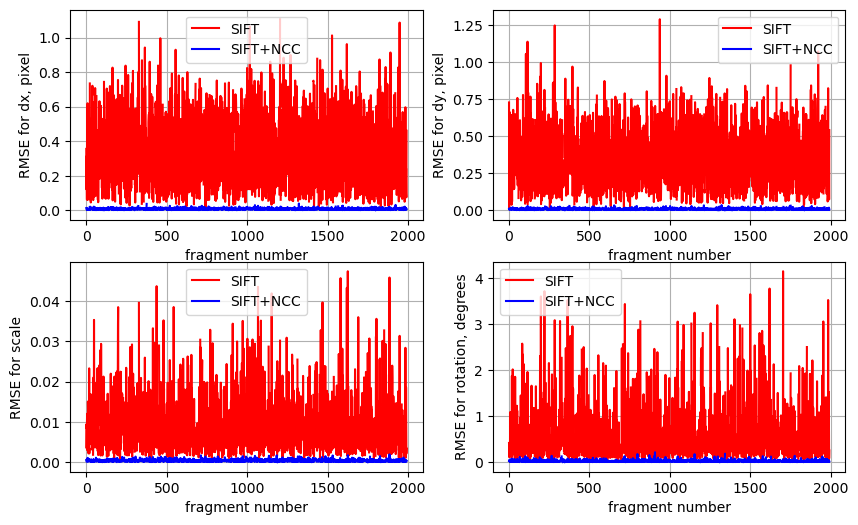

In [13]:
#%% Visualization: SIFT (1st registration step)   versus   SIFT+NCC (2nd step).
# =============================================================================
# test_No = np.arange(nPoints)
test_No = np.arange(len(df))    #   if (ri_s_HR <= N) and (ri_s_HR <= M):     # If the condition is not met - empty iteration.
    
plt.figure( figsize = (10,6) )
plt.subplot(221)
plt.plot(test_No, df.rmse_x__kp,'r')
plt.plot(test_No, df.rmse_x__ncc,'b')
plt.xlabel('fragment number')
plt.ylabel('RMSE for dx, pixel')
plt.legend(['SIFT','SIFT+NCC'])
plt.grid()

plt.subplot(222)
plt.plot(test_No, df.rmse_y__kp,'r')
plt.plot(test_No, df.rmse_y__ncc,'b')
plt.xlabel('fragment number')
plt.ylabel('RMSE for dy, pixel')
plt.legend(['SIFT','SIFT+NCC'])
plt.grid()

plt.subplot(223)
plt.plot(test_No, df.rmse_sc__kp,'r')
plt.plot(test_No, df.rmse_sc__ncc,'b')
plt.xlabel('fragment number')
plt.ylabel('RMSE for scale')
plt.legend(['SIFT','SIFT+NCC'])
plt.grid()

plt.subplot(224)
plt.plot(test_No, df.rmse_rot__kp,'r')
plt.plot(test_No, df.rmse_rot__ncc,'b')
plt.xlabel('fragment number')
plt.ylabel('RMSE for rotation, degrees')
plt.legend(['SIFT','SIFT+NCC'])
plt.grid()
# =============================================================================

# Write data

In [14]:
os.makedirs('/kaggle/working/created_data/tables/')

In [15]:
# --- DEBUG ---
#np.save('ri_ci__sample.npy', (ri,ci_clean,
#                              shift_x,shift_y,scale,rot) )  

write_path = '/kaggle/working/created_data/tables/'
result_file_name = mode + '__wSum__' + str(used_map) + '__' + str(nPoints) + \
                          'p.csv'
df.to_csv(write_path + result_file_name, index=True)

# Save images

In [16]:
import pickle

with open('ci_ri_list.pkl', 'wb') as f:
    pickle.dump(ci_ri_list, f)